# Modèle pre-entrainer XCEPTION : classification binaire COVID / SAIN (NORMAL) par extraction de features

In [1]:
# Chargement des modules necessaire :

import os

import random
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Model

In [2]:
# On declare les chemins vers les donnees :

trainDir = 'Data/TRAIN'
validationDir = 'Data/TEST'
        
# On declare les dimensions pour les images (224,224) :

img_width, img_height = 224, 224

# On liste et stocke les chemins des images :

ImageTRAINCOVID = os.listdir(trainDir + '/COVID')
ImageTRAINNORMAL = os.listdir(trainDir + '/NORMAL')

ImageTESTCOVID = os.listdir(validationDir + '/COVID')
ImageTESTNORMAL = os.listdir(validationDir + '/NORMAL')

# On affiche le nombre d'image trouve :

print('Il y a ' + str(len(ImageTRAINCOVID)) + ' images d\'entrainement de patient covid.') 
print('Il y a ' + str(len(ImageTRAINNORMAL)) + ' images d\'entrainement de patient non-covid.') 
print('Il y a ' + str(len(ImageTESTCOVID)) + ' images test de patient covid.') 
print('Il y a ' + str(len(ImageTESTNORMAL)) + ' images test de patient non-covid.') 

Il y a 460 images d'entrainement de patient covid.
Il y a 1266 images d'entrainement de patient non-covid.
Il y a 116 images test de patient covid.
Il y a 317 images test de patient non-covid.


TRAIN COVID


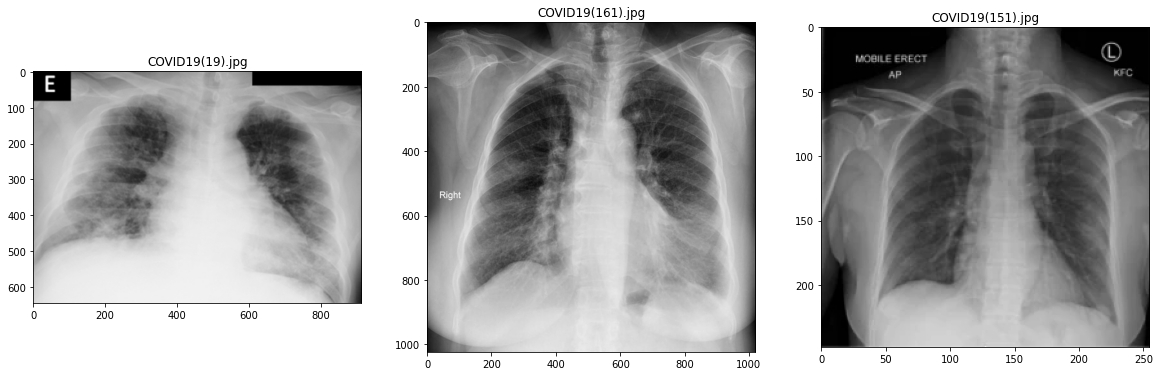

TEST COVID


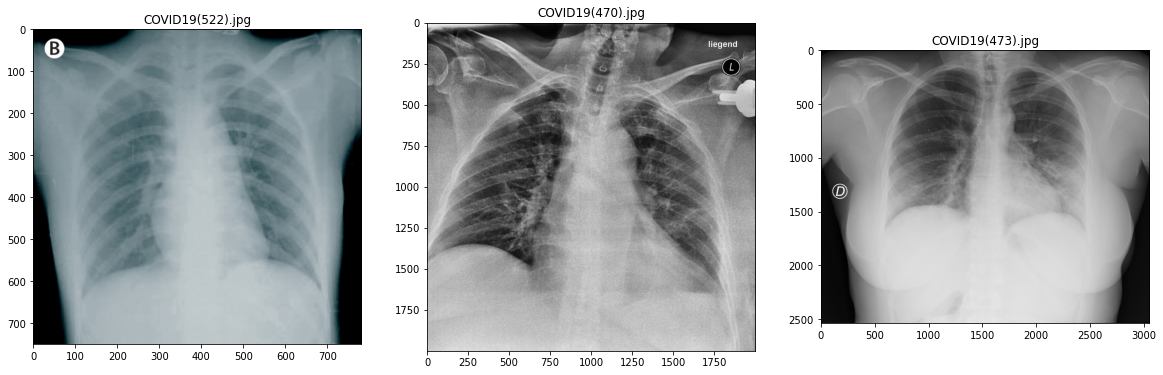

TRAIN NORMAL


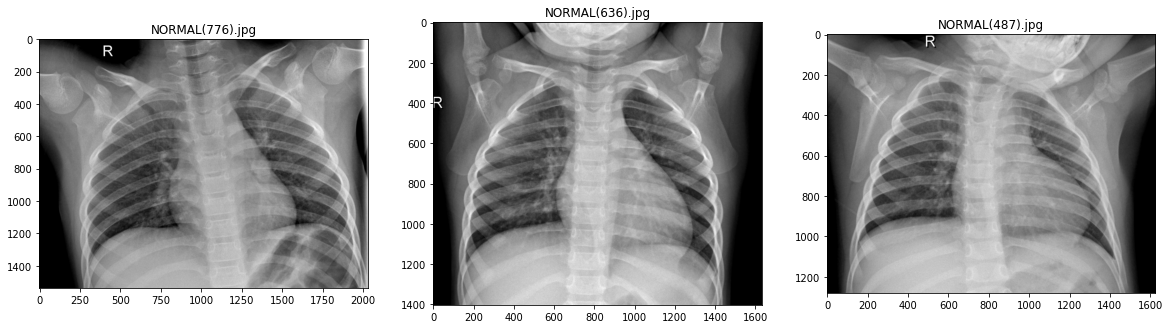

TEST NORMAL


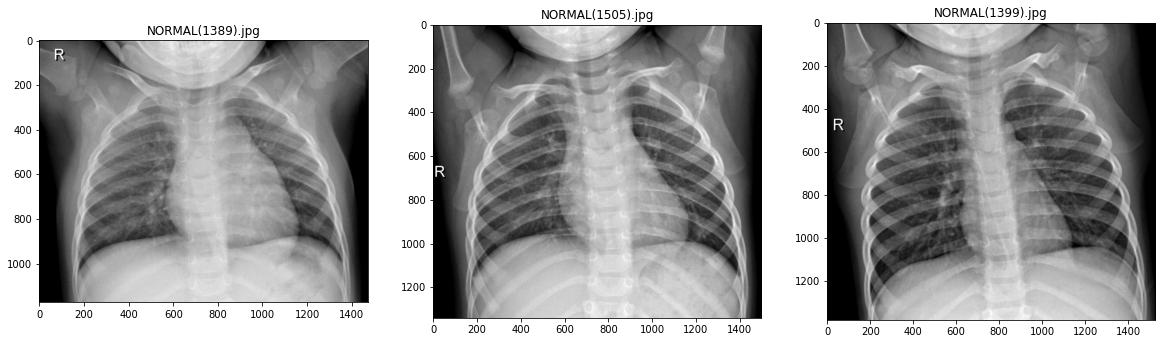

In [3]:
# Visualisation de 6 exemples en 2 lignes et 3 colonnes pour chaque classe :

# Visualisation de 6 exemples en 2 lignes et 3 colonnes pour chaque classe :

# TRAIN :

print("TRAIN COVID")


# COVID  :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINCOVID = random.choice(os.listdir(trainDir + '/COVID'))
    plt.imshow(plt.imread(os.path.join( trainDir +'/COVID',randomImageTRAINCOVID)), cmap='gray')
    plt.title(randomImageTRAINCOVID)
    
plt.show()

print("TEST COVID")
# COVID  :
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTCOVID = random.choice(os.listdir(validationDir + '/COVID'))
    plt.imshow(plt.imread(os.path.join( validationDir +'/COVID',randomImageTESTCOVID)), cmap='gray')
    plt.title(randomImageTESTCOVID)
    
plt.show()

print("TRAIN NORMAL")
# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINNORMAL = random.choice(os.listdir(trainDir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join( trainDir +'/NORMAL',randomImageTRAINNORMAL)), cmap='gray')
    plt.title(randomImageTRAINNORMAL)
    
plt.show()


# TEST:

print("TEST NORMAL")

# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTNORMAL = random.choice(os.listdir(validationDir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join(validationDir +'/NORMAL',randomImageTESTNORMAL)), cmap='gray')
    plt.title(randomImageTESTNORMAL)
    
plt.show()


In [4]:
# Preprocessing :

# On rescale les images :
datagen = ImageDataGenerator(rescale=1./255)

# On definit la batch size :
batch_size = 32

# On prepare les tableaux de donnees depuis les images :

train_generator_bottleneck = datagen.flow_from_directory(
        trainDir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validationDir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)


Found 1726 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


In [5]:
# Chargement de XCEPTION sans la partie fully-connected avec le reseau convolutif :

model_XCEPTION = applications.Xception(include_top=False, weights='imagenet')

In [ ]:
# On utilse le model XCEPTION pour extraire les features de nos images 
# (on fait recupere la sortie du reseau convolutionnel) :

train_features = model_XCEPTION.predict_generator(train_generator_bottleneck, 802 // batch_size)

np.save(open('models/trainFeatures_XCEPTION_AllData.npy', 'wb'), train_features)

validation_features = model_XCEPTION.predict_generator(validation_generator_bottleneck, 204 // batch_size)

# L'opération étant longue on enregistre les features obtenus :

np.save(open('models/validationFeatures_XCEPTION_AllData.npy', 'wb'), validation_features)

In [6]:
# Si l'operation à deja été effectuer on charge les features :

train_features = np.load(open('models/trainFeatures_XCEPTION_AllData.npy', 'rb'))

validation_features = np.load(open('models/validationFeatures_XCEPTION_AllData.npy', 'rb'))

In [7]:
# On definit les labels :

train_labels = np.array([0] * 400 + [1] * 400)

validation_labels = np.array([0] * 96 + [1] * 96)

# On peut maintenant tester plusieurs couche fully-connected à partir de ce modele :

In [8]:
# Premier modele : 

model_top1 = Sequential()
model_top1.add(Flatten(input_shape=train_features.shape[1:]))
model_top1.add(Dense(64, activation='relu'))
model_top1.add(Dropout(0.5))
model_top1.add(Dense(1, activation='sigmoid'))


# On compile :

model_top1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :

model_top1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,422,657
Trainable params: 6,422,657
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Second modele :

model_top2 = Sequential()
model_top2.add(Flatten(input_shape=train_features.shape[1:]))
model_top2.add(Dense(128, activation='relu'))
model_top2.add(Dropout(0.5))
model_top2.add(Dense(1, activation='sigmoid'))


# On compile :

model_top2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :

model_top2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 12,845,313
Trainable params: 12,845,313
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Troisieme modele :

model_top3 = Sequential()
model_top3.add(Flatten(input_shape=train_features.shape[1:]))
model_top3.add(Dense(256, activation='relu'))
model_top3.add(Dropout(0.5))
model_top3.add(Dense(1, activation='sigmoid'))


# On compile :

model_top3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :

model_top3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 25,690,625
Trainable params: 25,690,625
Non-trainable params: 0
_________________________________________________________________


In [1]:
# On definit les parametres pour l'entrainement :
epochs = 100
train_samples = 802
validation_samples = 204

# On definit les callbacks : 
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience = 10,restore_best_weights=True,),
]

SyntaxError: invalid syntax (<ipython-input-1-7a3efecb8d7d>, line 10)

In [12]:
# On entraine le modèle 1:

hystory1 = model_top1.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/10
25/25 [==============================] - 3s 105ms/step - loss: 5.5698 - accuracy: 0.7313 - val_loss: 0.3368 - val_accuracy: 0.8906
Epoch 2/10
25/25 [==============================] - 2s 72ms/step - loss: 0.3707 - accuracy: 0.9040 - val_loss: 0.4169 - val_accuracy: 0.8958
Epoch 3/10
25/25 [==============================] - 2s 76ms/step - loss: 0.4610 - accuracy: 0.8642 - val_loss: 0.4213 - val_accuracy: 0.8906
Epoch 4/10
25/25 [==============================] - 2s 74ms/step - loss: 0.3763 - accuracy: 0.8860 - val_loss: 0.3613 - val_accuracy: 0.8854
Epoch 5/10
25/25 [==============================] - 2s 76ms/step - loss: 0.3038 - accuracy: 0.8914 - val_loss: 0.4367 - val_accuracy: 0.8125
Epoch 6/10
25/25 [==============================] - 2s 75ms/step - loss: 0.3693 - accuracy: 0.9111 - val_loss: 0.3538 - val_accuracy: 0.8958
Epoch 7/10
25/25 [==============================] - 2s 74ms/step - loss: 0.2702 - accuracy: 0.9043 - val_loss: 0.3593 - val_accuracy: 0.8854
Epoch 8/10
2

In [ ]:
n_epochs = len(hystory1.history['loss'])
GenOptimale = n_epochs-10
print("la generation optimale est : ",GenOptimale)
model_top1.save_weights('../memory/Weights/xception_lightTop_224_224_'+str(GenOptimale)+'.h5')

In [13]:
# On entraine le modèle 2:

hystory2 = model_top2.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/10
25/25 [==============================] - 4s 137ms/step - loss: 6.3076 - accuracy: 0.7532 - val_loss: 1.8699 - val_accuracy: 0.8802
Epoch 2/10
25/25 [==============================] - 3s 126ms/step - loss: 0.9088 - accuracy: 0.8714 - val_loss: 0.4277 - val_accuracy: 0.7969
Epoch 3/10
25/25 [==============================] - 3s 127ms/step - loss: 0.3392 - accuracy: 0.9089 - val_loss: 0.3640 - val_accuracy: 0.8958
Epoch 4/10
25/25 [==============================] - 3s 128ms/step - loss: 0.4900 - accuracy: 0.8831 - val_loss: 0.3865 - val_accuracy: 0.8958
Epoch 5/10
25/25 [==============================] - 3s 127ms/step - loss: 0.4317 - accuracy: 0.9158 - val_loss: 0.4998 - val_accuracy: 0.8854
Epoch 6/10
25/25 [==============================] - 3s 128ms/step - loss: 0.3143 - accuracy: 0.9028 - val_loss: 0.6890 - val_accuracy: 0.8958
Epoch 7/10
25/25 [==============================] - 3s 126ms/step - loss: 0.2976 - accuracy: 0.9182 - val_loss: 0.6457 - val_accuracy: 0.8906
Epoch 

In [2]:
n_epochs = len(hystory2.history['loss'])
GenOptimale = n_epochs-10
print("la generation optimale est : ",GenOptimale)
model_top2.save_weights('../memory/Weights/xception_mediumTop_224_224_'+str(GenOptimale)+'.h5')

NameError: name 'history2' is not defined

In [14]:
# On entraine le modèle 3:

hystory3 = model_top3.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/10
25/25 [==============================] - 7s 243ms/step - loss: 11.6818 - accuracy: 0.7427 - val_loss: 5.5791 - val_accuracy: 0.5833
Epoch 2/10
25/25 [==============================] - 6s 237ms/step - loss: 2.8759 - accuracy: 0.8554 - val_loss: 1.0681 - val_accuracy: 0.7865
Epoch 3/10
25/25 [==============================] - 6s 237ms/step - loss: 0.8281 - accuracy: 0.8501 - val_loss: 0.5615 - val_accuracy: 0.8854
Epoch 4/10
25/25 [==============================] - 6s 236ms/step - loss: 0.3114 - accuracy: 0.9076 - val_loss: 1.4726 - val_accuracy: 0.5729
Epoch 5/10
25/25 [==============================] - 6s 236ms/step - loss: 0.7749 - accuracy: 0.8704 - val_loss: 1.3325 - val_accuracy: 0.8958
Epoch 6/10
25/25 [==============================] - 6s 237ms/step - loss: 0.2862 - accuracy: 0.9440 - val_loss: 0.8999 - val_accuracy: 0.7396
Epoch 7/10
25/25 [==============================] - 6s 235ms/step - loss: 0.3801 - accuracy: 0.8869 - val_loss: 1.1140 - val_accuracy: 0.8906
Epoch

In [3]:
n_epochs = len(hystory3.history['loss'])
GenOptimale = n_epochs-10
print("la generation optimale est : ",GenOptimale)
model_top3.save_weights('../memory/Weights/xception_heavyTop_224_224_'+str(GenOptimale)+'.h5')

NameError: name 'hystory2' is not defined

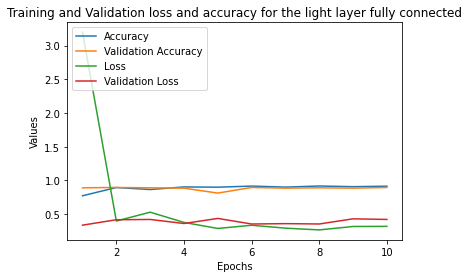

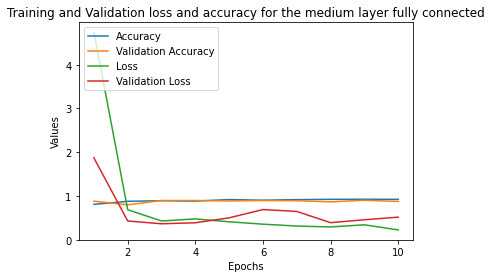

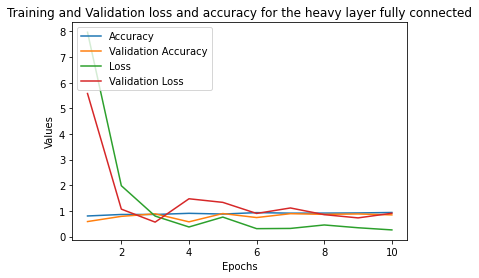

In [28]:
# Visualisation de l'entrainement :

epochs = range(1,11)
plt.plot(epochs, hystory1.history['accuracy'], label='Accuracy')
plt.plot(epochs, hystory1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, hystory1.history['loss'], label='Loss')
plt.plot(epochs, hystory1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the light layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()

epochs = range(1,11)
plt.plot(epochs, hystory2.history['accuracy'], label='Accuracy')
plt.plot(epochs, hystory2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, hystory2.history['loss'], label='Loss')
plt.plot(epochs, hystory2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the medium layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()

epochs = range(1,11)
plt.plot(epochs, hystory3.history['accuracy'], label='Accuracy')
plt.plot(epochs, hystory3.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, hystory3.history['loss'], label='Loss')
plt.plot(epochs, hystory3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the heavy layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()



In [23]:
# On evalue le modèle 1:

model_top1.evaluate(validation_features, validation_labels,verbose=2)

# Avec les donnes de validation :

# Avec les donnes de test :

# On prend quelques exemples aleatoires :

    # on visualise, on test , on affiche :

6/6 - 0s - loss: 0.4217 - accuracy: 0.8958


[0.4217142164707184, 0.8958333134651184]

In [24]:
# On evalue le modèle 2:

model_top2.evaluate(validation_features, validation_labels,verbose=2)

6/6 - 0s - loss: 0.5157 - accuracy: 0.8750


[0.5156974792480469, 0.875]

In [25]:
# On evalue le modèle 3:

model_top3.evaluate(validation_features, validation_labels,verbose=2)

6/6 - 0s - loss: 0.9075 - accuracy: 0.8438


[0.907459020614624, 0.84375]

In [ ]:
# Data augmentation :

# On reproduit le processus puis on compare :

## Enregistrements (facultatifs)

In [27]:
    #On enregistre l'historique:

np.save('../memory/history/historique_chourouk_xception_224_224_light_10G.npy',hystory1.history)
np.save('../memory/history/historique_chourouk_xception_224_224_medium_10G.npy',hystory2.history)
np.save('../memory/history/historique_chourouk_xception_224_224_heavy_10G.npy',hystory3.history)